<a href="https://colab.research.google.com/github/douglasmmachado/MedicineConsumption/blob/main/notebooks/time_series/unified_approach/2_Data_Treatment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2 - Removing outliers, understanding the data, visualization of components for each dataset, common period for the different hospitals, data aggregation and transformation of categorical features into numerical ones.

---



---



# Loading libs and database

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import math as m

df_url ="https://raw.githubusercontent.com/douglasmmachado/MedicineConsumption/main/datasets/unified_approach/df_unified.csv"


df = pd.read_csv(df_url)



categorical_features = ['ID_REF', 'ID_SITE_RATTACHE', 'CODE_ATC', 'HOSPI_CODE_UCD']
date_features = ['DATE_MOUV', 'WEEK', 'MONTH', 'YEAR']
numerical_features = ['N_UFS', 'QUANTITY', 'N_ETB', 'POPULATION', 'P_MEDICAL', 'PN_MEDICAL', 'LIT_HC', 'LIT_HP', 'SEJ_MCO', 'SEJ_HAD', 'SEJ_PSY', 'SEJ_SSR']

df['DATE_MOUV'] = pd.to_datetime(df['DATE_MOUV'],
              format='%Y-%m-%d')  # Changed the type of date too

df['YEAR'] = df['DATE_MOUV'].dt.year
df['MONTH'] = df['DATE_MOUV'].dt.month
df['WEEK'] = df['DATE_MOUV'].dt.isocalendar().week


for column in categorical_features:
  df[column] = df[column].astype('string')

medicines = ['3400892088310','3400892075761','3400892203645',
             '3400892065366','3400892052120','3400891996128',
             '3400893826706','3400893736135','3400893875490',
             '3400890837149','3400891235203','3400891225037',
             '3400891191226','3400892729589','3400892745848',
             '3400892697789','3400892761527','3400893022634',
             '3400892761695','3400892669236','3400892508566']

## 2.1 - Visualisation of data range and data composition

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75684 entries, 0 to 75683
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID_REF            75684 non-null  string        
 1   ID_SITE_RATTACHE  75684 non-null  string        
 2   CODE_ATC          75684 non-null  string        
 3   HOSPI_CODE_UCD    75684 non-null  string        
 4   DATE_MOUV         75684 non-null  datetime64[ns]
 5   N_UFS             75684 non-null  int64         
 6   QUANTITY          75684 non-null  float64       
 7   WEEK              75684 non-null  int64         
 8   MONTH             75684 non-null  int64         
 9   YEAR              75684 non-null  int64         
 10  N_ETB             75684 non-null  int64         
 11  POPULATION        75684 non-null  float64       
 12  P_MEDICAL         75684 non-null  int64         
 13  PN_MEDICAL        75684 non-null  int64         
 14  LIT_HC            7568

In [ ]:
def visualize_distribution(df, features):
  '''
    Plot of distribution for the numerical features after removing the outliers
  '''

  fig, axes = plt.subplots(4, 3,sharex=False, figsize=(20,20))

  i = 0
  j = 0
  for column in features:
    sns.histplot(df[column], kde=True, stat="density", kde_kws=dict(cut=3),alpha=.4, edgecolor=(1, 1, 1, .4),ax=axes[i, j]).set(title='Distribution of: ' + str(column))
    if j == 2:
      i += 1
      j = 0
    else:
      j+=1

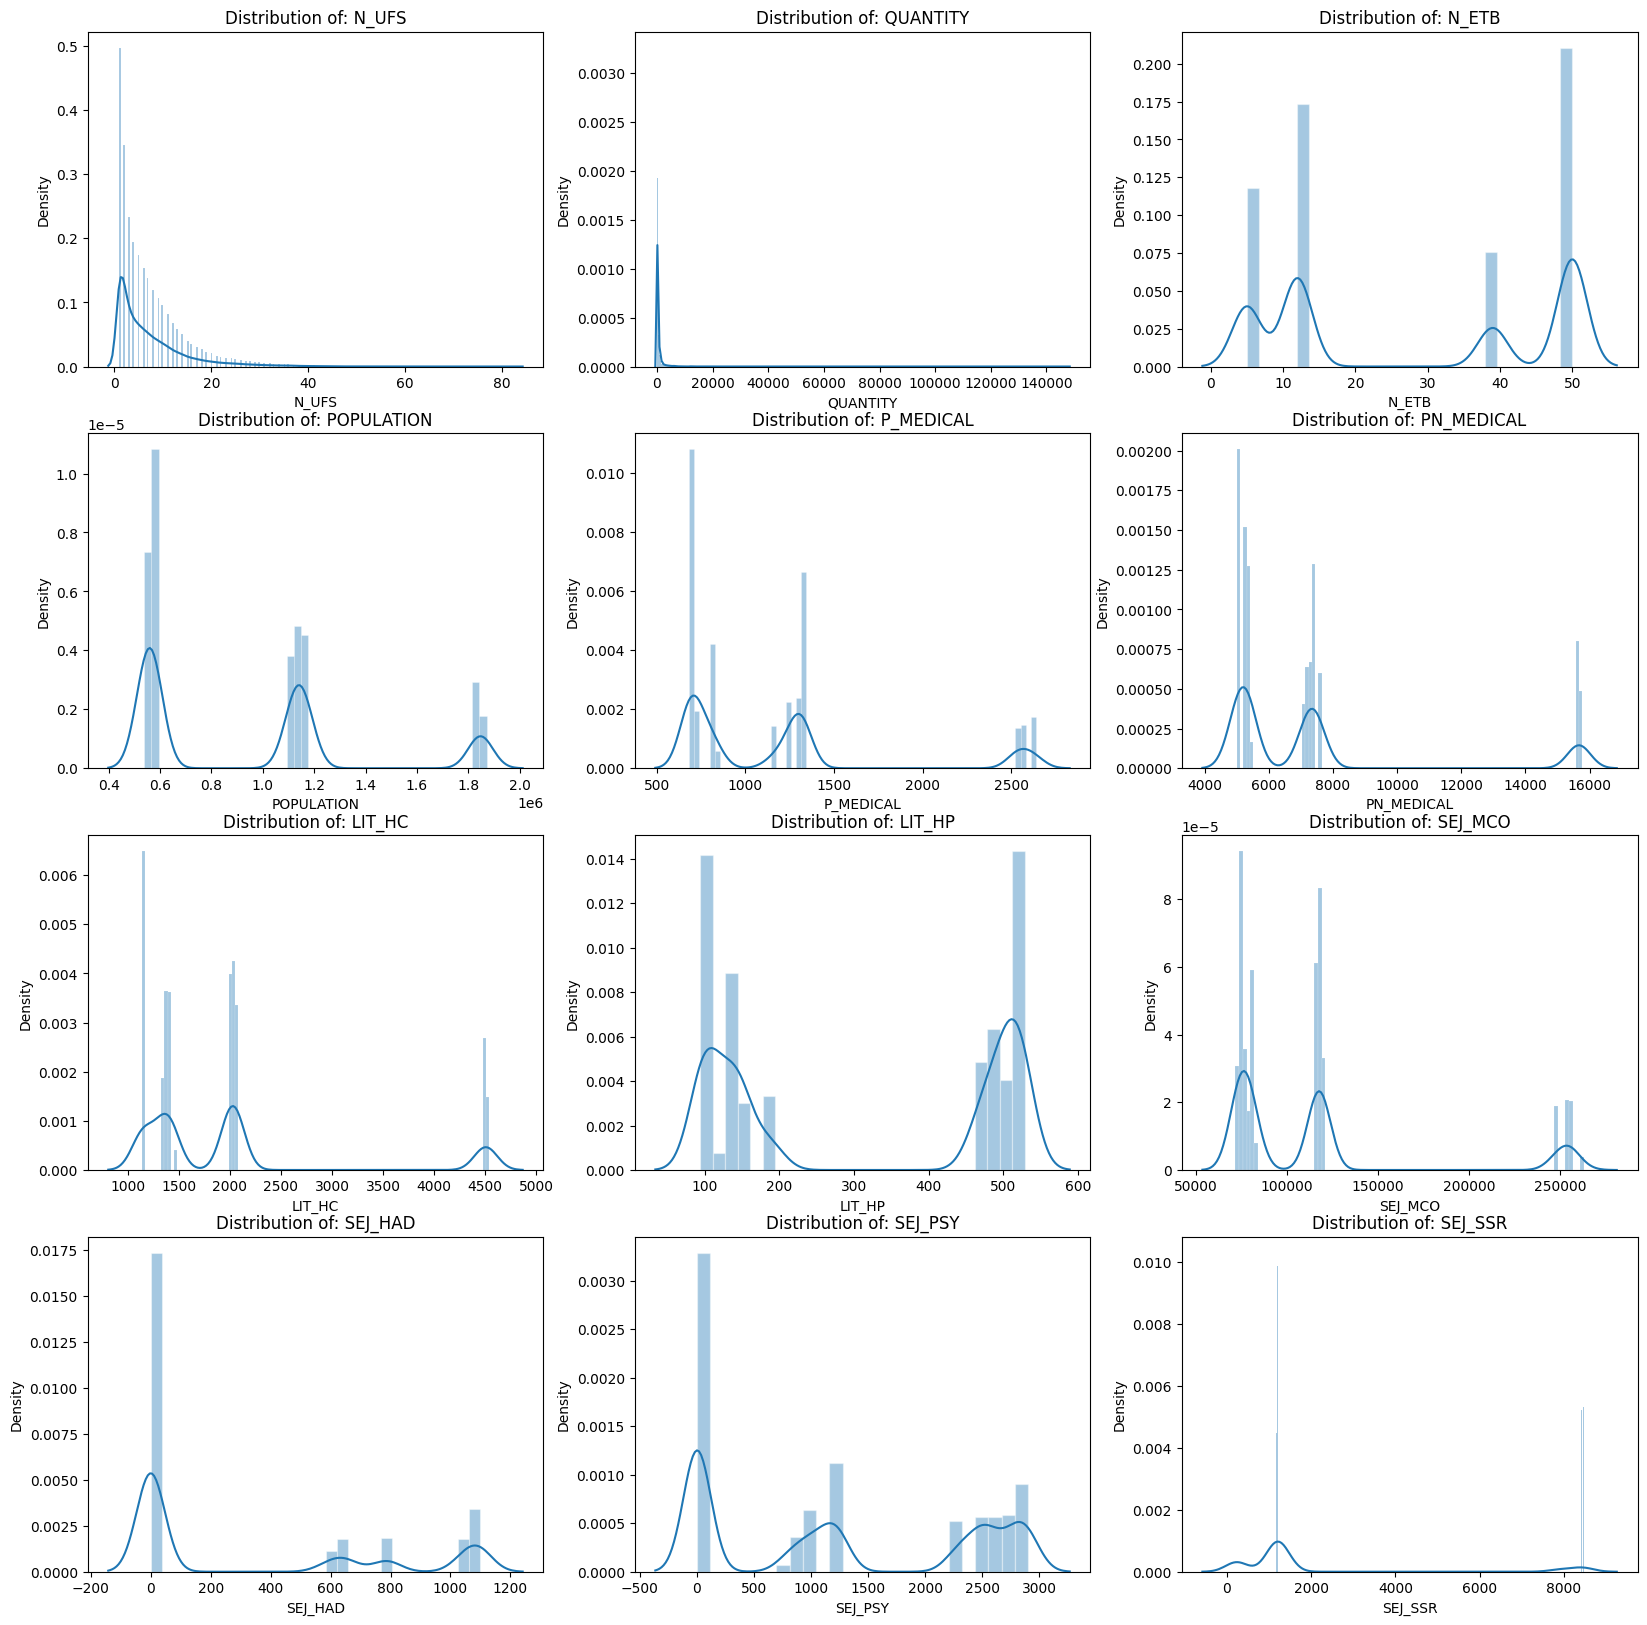

In [ ]:
visualize_distribution(df, numerical_features)

## 2.2 - Removing outliers by hospital and by drug

In [3]:
def remove_outliers(df, columns, verbose=False):
    N_macro = df.shape[0]
    new_df = pd.DataFrame()  # Create an empty DataFrame to store the filtered values
    removed_outliers = 0  # Variable to keep track of the total number of removed outliers

    for col in columns:
        for ucd_code in df['HOSPI_CODE_UCD'].unique():
            # Filter the dataframe for the specific HOSPI_CODE_UCD
            df_subset = df[df['HOSPI_CODE_UCD'] == ucd_code]
            N = df_subset.shape[0]

            # Calculate the statistics for the column within the HOSPI_CODE_UCD subset
            q25, q75 = np.percentile(df_subset[col], [25, 75])
            iqr = q75 - q25
            lower, upper = q25 - (iqr * 1.5), q75 + (iqr * 1.5)

            # Remove outliers based on the cutoff values within the HOSPI_CODE_UCD subset
            df_filtered = df_subset[(df_subset[col] >= lower) & (df_subset[col] <= upper)]
            N_new = df_filtered.shape[0]
            delta = N - N_new

            # Update the new DataFrame with the filtered values
            new_df = pd.concat([new_df, df_filtered])

            if verbose:
                if delta > 0:
                    print(f'Column: {col}')
                    print(f'HOSPI_CODE_UCD: {ucd_code}')
                    print(f'Removed outliers: {delta}')
                    print(f'Removed percentage: {(100 * delta / N):.3}%')
                    print()

            removed_outliers += delta

    new_df.reset_index(drop=True, inplace=True)
    print('N_old:', N_macro)
    N_macro_new = new_df.shape[0]
    print('N_new:', N_macro_new)
    delta = N_macro - N_macro_new
    print(f'Total removed outliers: {(100 * delta / N_macro):.3}%')

    return new_df


In [4]:
print("-"*100)
df_wo_outliers = pd.concat([remove_outliers(df[df['ID_SITE_RATTACHE']=='HOSPI_1'], ["QUANTITY"], verbose = False),
                                remove_outliers(df[df['ID_SITE_RATTACHE']=='HOSPI_2'], ["QUANTITY"], verbose = False),
                                remove_outliers(df[df['ID_SITE_RATTACHE']=='HOSPI_3'], ["QUANTITY"], verbose = False),
                                remove_outliers(df[df['ID_SITE_RATTACHE']=='HOSPI_4'], ["QUANTITY"], verbose = False)])


----------------------------------------------------------------------------------------------------
N_old: 22725
N_new: 21715
Total removed outliers: 4.44%
N_old: 15439
N_new: 14953
Total removed outliers: 3.15%
N_old: 27591
N_new: 26801
Total removed outliers: 2.86%
N_old: 9929
N_new: 9638
Total removed outliers: 2.93%


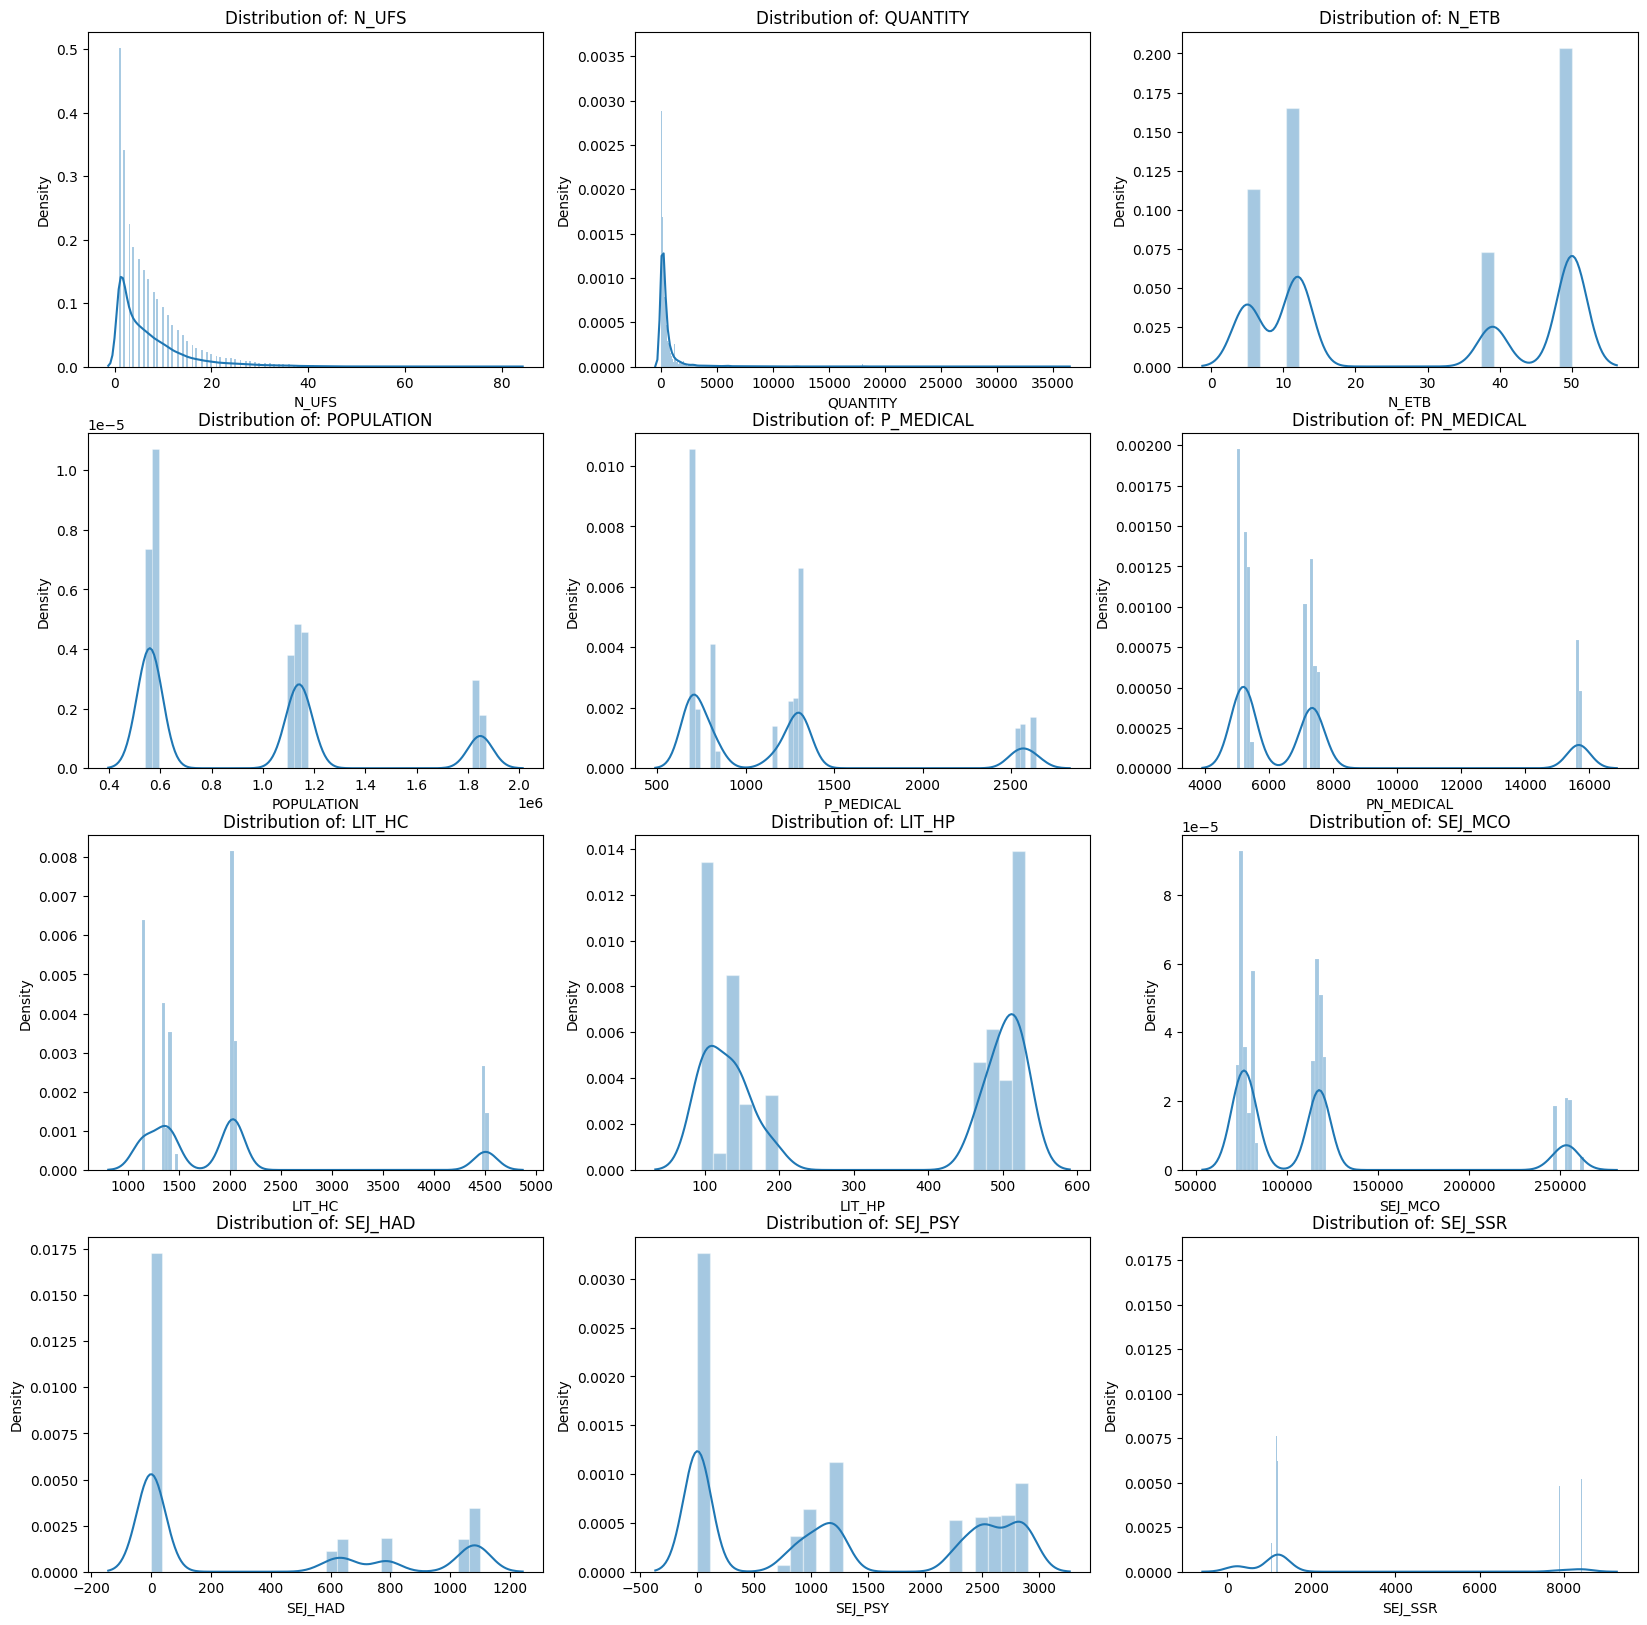

In [ ]:
visualize_distribution(df_wo_outliers, numerical_features)

In [ ]:
for column in categorical_features:
  df_wo_outliers[column] = df_wo_outliers[column].astype('string')

## 2.3 - Define common period for data usage

In [5]:
# Identifying a common period for the different timeseries
min_date_h1 = df_wo_outliers[df_wo_outliers["ID_SITE_RATTACHE"] == "HOSPI_1"]["DATE_MOUV"].min()
min_date_h2 = df_wo_outliers[df_wo_outliers["ID_SITE_RATTACHE"] == "HOSPI_2"]["DATE_MOUV"].min()
min_date_h3 = df_wo_outliers[df_wo_outliers["ID_SITE_RATTACHE"] == "HOSPI_3"]["DATE_MOUV"].min()
min_date_h4 = df_wo_outliers[df_wo_outliers["ID_SITE_RATTACHE"] == "HOSPI_4"]["DATE_MOUV"].min()

print(f'Min dates:' + f'\n H1: {min_date_h1}' + f'\n H2: {min_date_h2}' + f'\n H3: {min_date_h3}' + f'\n H4: {min_date_h4}')

max_date_h1 = df_wo_outliers[df_wo_outliers["ID_SITE_RATTACHE"] == "HOSPI_1"]["DATE_MOUV"].max()
max_date_h2 = df_wo_outliers[df_wo_outliers["ID_SITE_RATTACHE"] == "HOSPI_2"]["DATE_MOUV"].max()
max_date_h3 = df_wo_outliers[df_wo_outliers["ID_SITE_RATTACHE"] == "HOSPI_3"]["DATE_MOUV"].max()
max_date_h4 = df_wo_outliers[df_wo_outliers["ID_SITE_RATTACHE"] == "HOSPI_4"]["DATE_MOUV"].max()

print(f'\n Max dates:' + f'\n H1: {max_date_h1}' + f'\n H2: {max_date_h2}' + f'\n H3: {max_date_h3}' + f'\n H4: {max_date_h4}')

init = min(min_date_h1, min_date_h2, min_date_h3, min_date_h4)
ending = max(max_date_h1, max_date_h2, max_date_h3, max_date_h4)


print('\n')
print(f'Begin date: {init}')
print(f'End date: {ending}')

Min dates:
 H1: 2013-06-18 00:00:00
 H2: 2017-03-30 00:00:00
 H3: 2014-05-20 00:00:00
 H4: 2016-01-01 00:00:00

 Max dates:
 H1: 2019-12-30 00:00:00
 H2: 2019-12-30 00:00:00
 H3: 2019-12-30 00:00:00
 H4: 2019-03-05 00:00:00


Begin date: 2013-06-18 00:00:00
End date: 2019-12-30 00:00:00


In [6]:
import plotly.graph_objects as go

for medicine in medicines:
    periods = []
    hospitals = ['HOSPI_1', 'HOSPI_2', 'HOSPI_3', 'HOSPI_4']

    for hospital in hospitals:
        print()
        print('-'*100)
        filtered_df = df_wo_outliers[(df_wo_outliers["HOSPI_CODE_UCD"] == str(medicine)) & (df_wo_outliers["ID_SITE_RATTACHE"] == hospital)]
        init = filtered_df["DATE_MOUV"].min()
        ending = filtered_df["DATE_MOUV"].max()

        periods.append((init, ending))

        print(f"Period of timeseries of UCD_{medicine} in {hospital}:")
        print(f"Initial date: {init}")
        print(f"Ending date: {ending}")

    fig = go.Figure()

    for idx, period in enumerate(periods, start=1):
        fig.add_trace(go.Scatter(
            x=[period[0], period[1]],
            y=[idx, idx],
            mode='lines',
            line=dict(width=10),
            name=f'Hospital {idx}'
        ))

    fig.update_layout(
        title=f"Common Periods for UCD_{medicine}",
        xaxis=dict(
            title="Date",
            tickangle=45,
            showgrid=True,
            gridwidth=1,
            gridcolor='lightgray'
        ),
        yaxis=dict(
            title="Hospital",
            showgrid=True,
            gridwidth=1,
            gridcolor='lightgray',
            tickmode='array',
            tickvals=list(range(1, 5)),
            ticktext=[f'Hospital {idx}' for idx in range(1, 5)]
        )
    )

    fig.show()
    print('-'*100)
    print()





----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892088310 in HOSPI_1:
Initial date: 2013-06-26 00:00:00
Ending date: 2019-12-04 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892088310 in HOSPI_2:
Initial date: 2017-03-30 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892088310 in HOSPI_3:
Initial date: 2014-05-20 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892088310 in HOSPI_4:
Initial date: 2017-06-27 00:00:00
Ending date: 2019-03-04 00:00:00


----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892075761 in HOSPI_1:
Initial date: 2013-06-18 00:00:00
Ending date: 2019-12-23 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892075761 in HOSPI_2:
Initial date: 2017-03-30 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892075761 in HOSPI_3:
Initial date: 2014-05-20 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892075761 in HOSPI_4:
Initial date: 2016-01-05 00:00:00
Ending date: 2019-03-05 00:00:00


----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892203645 in HOSPI_1:
Initial date: 2013-07-05 00:00:00
Ending date: 2019-10-20 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892203645 in HOSPI_2:
Initial date: 2017-03-30 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892203645 in HOSPI_3:
Initial date: 2014-05-20 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892203645 in HOSPI_4:
Initial date: 2016-01-04 00:00:00
Ending date: 2019-03-04 00:00:00


----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892065366 in HOSPI_1:
Initial date: 2013-06-19 00:00:00
Ending date: 2019-10-19 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892065366 in HOSPI_2:
Initial date: 2017-03-30 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892065366 in HOSPI_3:
Initial date: 2014-05-20 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892065366 in HOSPI_4:
Initial date: 2016-01-04 00:00:00
Ending date: 2019-03-05 00:00:00


----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892052120 in HOSPI_1:
Initial date: 2014-04-17 00:00:00
Ending date: 2019-12-22 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892052120 in HOSPI_2:
Initial date: 2017-03-30 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892052120 in HOSPI_3:
Initial date: 2014-05-20 00:00:00
Ending date: 2019-12-27 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892052120 in HOSPI_4:
Initial date: 2016-01-04 00:00:00
Ending date: 2019-03-05 00:00:00


----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400891996128 in HOSPI_1:
Initial date: 2013-06-18 00:00:00
Ending date: 2019-12-08 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400891996128 in HOSPI_2:
Initial date: 2017-03-30 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400891996128 in HOSPI_3:
Initial date: 2014-05-20 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400891996128 in HOSPI_4:
Initial date: 2016-01-01 00:00:00
Ending date: 2019-03-05 00:00:00


----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400893826706 in HOSPI_1:
Initial date: 2013-07-12 00:00:00
Ending date: 2019-10-18 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400893826706 in HOSPI_2:
Initial date: 2017-03-30 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400893826706 in HOSPI_3:
Initial date: 2014-05-20 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400893826706 in HOSPI_4:
Initial date: 2016-01-04 00:00:00
Ending date: 2019-03-05 00:00:00


----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400893736135 in HOSPI_1:
Initial date: 2013-07-02 00:00:00
Ending date: 2019-10-18 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400893736135 in HOSPI_2:
Initial date: 2017-06-22 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400893736135 in HOSPI_3:
Initial date: 2014-05-20 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400893736135 in HOSPI_4:
Initial date: 2016-01-25 00:00:00
Ending date: 2019-03-05 00:00:00


----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400893875490 in HOSPI_1:
Initial date: 2013-07-26 00:00:00
Ending date: 2019-10-19 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400893875490 in HOSPI_2:
Initial date: 2017-03-30 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400893875490 in HOSPI_3:
Initial date: 2014-05-20 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400893875490 in HOSPI_4:
Initial date: 2016-01-04 00:00:00
Ending date: 2019-03-01 00:00:00


----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400890837149 in HOSPI_1:
Initial date: 2013-07-17 00:00:00
Ending date: 2019-11-24 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400890837149 in HOSPI_2:
Initial date: 2017-03-30 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400890837149 in HOSPI_3:
Initial date: 2014-05-20 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400890837149 in HOSPI_4:
Initial date: 2016-01-04 00:00:00
Ending date: 2019-03-05 00:00:00


----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400891235203 in HOSPI_1:
Initial date: 2014-03-19 00:00:00
Ending date: 2019-12-28 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400891235203 in HOSPI_2:
Initial date: 2017-03-30 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400891235203 in HOSPI_3:
Initial date: 2014-05-20 00:00:00
Ending date: 2019-04-19 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400891235203 in HOSPI_4:
Initial date: 2016-01-05 00:00:00
Ending date: 2019-03-05 00:00:00


----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400891225037 in HOSPI_1:
Initial date: 2013-06-18 00:00:00
Ending date: 2019-12-25 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400891225037 in HOSPI_2:
Initial date: 2017-03-30 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400891225037 in HOSPI_3:
Initial date: 2014-05-20 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400891225037 in HOSPI_4:
Initial date: 2016-01-04 00:00:00
Ending date: 2019-03-05 00:00:00


----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400891191226 in HOSPI_1:
Initial date: 2013-06-19 00:00:00
Ending date: 2019-10-19 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400891191226 in HOSPI_2:
Initial date: 2017-03-30 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400891191226 in HOSPI_3:
Initial date: 2014-05-20 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400891191226 in HOSPI_4:
Initial date: 2016-01-04 00:00:00
Ending date: 2019-03-05 00:00:00


----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892729589 in HOSPI_1:
Initial date: 2014-04-08 00:00:00
Ending date: 2019-12-08 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892729589 in HOSPI_2:
Initial date: 2017-04-01 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892729589 in HOSPI_3:
Initial date: 2014-05-20 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892729589 in HOSPI_4:
Initial date: 2016-01-04 00:00:00
Ending date: 2019-03-04 00:00:00


----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892745848 in HOSPI_1:
Initial date: 2015-07-18 00:00:00
Ending date: 2019-03-16 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892745848 in HOSPI_2:
Initial date: 2017-03-30 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892745848 in HOSPI_3:
Initial date: 2014-05-21 00:00:00
Ending date: 2019-12-27 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892745848 in HOSPI_4:
Initial date: 2016-01-07 00:00:00
Ending date: 2019-03-05 00:00:00


----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892697789 in HOSPI_1:
Initial date: 2013-07-19 00:00:00
Ending date: 2019-10-18 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892697789 in HOSPI_2:
Initial date: 2017-03-30 00:00:00
Ending date: 2019-12-27 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892697789 in HOSPI_3:
Initial date: 2014-05-20 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892697789 in HOSPI_4:
Initial date: 2016-01-04 00:00:00
Ending date: 2019-03-04 00:00:00


----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892761527 in HOSPI_1:
Initial date: 2013-07-22 00:00:00
Ending date: 2019-10-19 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892761527 in HOSPI_2:
Initial date: 2017-03-30 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892761527 in HOSPI_3:
Initial date: 2014-05-20 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892761527 in HOSPI_4:
Initial date: 2016-01-04 00:00:00
Ending date: 2019-03-04 00:00:00


----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400893022634 in HOSPI_1:
Initial date: 2014-01-22 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400893022634 in HOSPI_2:
Initial date: 2017-03-30 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400893022634 in HOSPI_3:
Initial date: 2014-06-06 00:00:00
Ending date: 2019-11-08 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400893022634 in HOSPI_4:
Initial date: 2018-08-03 00:00:00
Ending date: 2019-03-04 00:00:00


----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892761695 in HOSPI_1:
Initial date: 2013-06-26 00:00:00
Ending date: 2019-10-19 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892761695 in HOSPI_2:
Initial date: 2017-03-30 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892761695 in HOSPI_3:
Initial date: 2014-05-20 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892761695 in HOSPI_4:
Initial date: 2016-01-04 00:00:00
Ending date: 2019-03-05 00:00:00


----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892669236 in HOSPI_1:
Initial date: 2013-06-27 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892669236 in HOSPI_2:
Initial date: 2017-03-30 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892669236 in HOSPI_3:
Initial date: 2014-05-20 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892669236 in HOSPI_4:
Initial date: 2016-01-04 00:00:00
Ending date: 2019-02-27 00:00:00


----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892508566 in HOSPI_1:
Initial date: 2013-09-05 00:00:00
Ending date: 2019-10-18 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892508566 in HOSPI_2:
Initial date: 2018-02-06 00:00:00
Ending date: 2019-12-20 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892508566 in HOSPI_3:
Initial date: 2014-05-20 00:00:00
Ending date: 2019-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Period of timeseries of UCD_3400892508566 in HOSPI_4:
Initial date: 2016-01-04 00:00:00
Ending date: 2019-03-05 00:00:00


----------------------------------------------------------------------------------------------------



In [7]:
common_period = pd.date_range(start=pd.Timestamp(year=init.year, month=init.month, day=1), end=pd.Timestamp(year=ending.year, month=ending.month, day=31))
df_cp = df_wo_outliers[(df_wo_outliers["DATE_MOUV"] >= init) & (df_wo_outliers["DATE_MOUV"] <= ending)].copy()

In [8]:
common_period

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2019-03-22', '2019-03-23', '2019-03-24', '2019-03-25',
               '2019-03-26', '2019-03-27', '2019-03-28', '2019-03-29',
               '2019-03-30', '2019-03-31'],
              dtype='datetime64[ns]', length=1186, freq='D')

## 2.4 - Fill gaps in data for eache medicine and for each hospital

In [9]:
def fill_gap_timeseries(df_cp, common_period,hospital='', visu=False):
    for medicine in df.HOSPI_CODE_UCD.unique():
        id_ref = df_cp[df_cp["HOSPI_CODE_UCD"] == medicine]["ID_REF"].values[0]
        cod_atc = df_cp[df_cp["HOSPI_CODE_UCD"] == medicine]["CODE_ATC"].values[0]

        data = {
            'DATE_MOUV': list(common_period),
            'HOSPI_CODE_UCD': [medicine] * len(common_period),
            'ID_REF': [id_ref] * len(common_period),
            'CODE_ATC': [cod_atc] * len(common_period),
        }

        df_medicine = pd.DataFrame(data)

        df_medicine_resampled = pd.merge(df_medicine, df_cp.astype({'DATE_MOUV': 'datetime64[ns]'}),
                                         on=['DATE_MOUV', 'HOSPI_CODE_UCD', 'ID_REF', 'CODE_ATC'], how='left')

        df_medicine_resampled = pd.merge(df_medicine, df_cp, on=['DATE_MOUV', 'HOSPI_CODE_UCD', 'ID_REF', 'CODE_ATC'], how='left')
        df_medicine_resampled['N_ETB'] = df_medicine_resampled['N_ETB'].fillna(method='ffill').fillna(method='bfill')
        df_medicine_resampled['N_UFS'] = df_medicine_resampled['N_UFS'].fillna(method='ffill').fillna(method='bfill')
        df_medicine_resampled['POPULATION'] = df_medicine_resampled['POPULATION'].fillna(method='ffill').fillna(method='bfill')
        df_medicine_resampled['P_MEDICAL'] = df_medicine_resampled['P_MEDICAL'].fillna(method='ffill').fillna(method='bfill')
        df_medicine_resampled['PN_MEDICAL'] = df_medicine_resampled['PN_MEDICAL'].fillna(method='ffill').fillna(method='bfill')
        df_medicine_resampled['LIT_HC'] = df_medicine_resampled['LIT_HC'].fillna(method='ffill').fillna(method='bfill')
        df_medicine_resampled['LIT_HP'] = df_medicine_resampled['LIT_HP'].fillna(method='ffill').fillna(method='bfill')
        df_medicine_resampled['SEJ_MCO'] = df_medicine_resampled['SEJ_MCO'].fillna(method='ffill').fillna(method='bfill')
        df_medicine_resampled['SEJ_HAD'] = df_medicine_resampled['SEJ_HAD'].fillna(method='ffill').fillna(method='bfill')
        df_medicine_resampled['SEJ_PSY'] = df_medicine_resampled['SEJ_PSY'].fillna(method='ffill').fillna(method='bfill')
        df_medicine_resampled['SEJ_SSR'] = df_medicine_resampled['SEJ_SSR'].fillna(method='ffill').fillna(method='bfill')
        df_medicine_resampled['SEJ_SLD'] = df_medicine_resampled['SEJ_SLD'].fillna(method='ffill').fillna(method='bfill')
        df_medicine_resampled['QUANTITY'] = df_medicine_resampled['QUANTITY'].fillna(0)

        df_cp = df_cp[df_cp["HOSPI_CODE_UCD"] != medicine]
        df_cp = pd.concat([df_cp, df_medicine_resampled], ignore_index=True)

    df_cp = df_cp.sort_values(by=['DATE_MOUV']).reset_index(drop=True)
    df_cp["WEEK"] = df_cp["DATE_MOUV"].dt.isocalendar().week
    df_cp["YEAR"] = df_cp["DATE_MOUV"].dt.year
    df_cp["MONTH"] = df_cp["DATE_MOUV"].dt.month
    df_cp["ID_SITE_RATTACHE"] = hospital
    x = common_period

    if visu:
        fig, axs = plt.subplots(7, 3, figsize=(25, 25))

        for i, medicine in enumerate(df.HOSPI_CODE_UCD.unique()):
            row = i // 3  # Calculate the row index
            col = i % 3   # Calculate the column index

            ax = axs[row, col]  # Get the corresponding subplot

            y = df_cp[df_cp["HOSPI_CODE_UCD"] == medicine]["QUANTITY"]
            ax.scatter(x, y)
            ax.set_title(f'Consumption quantity of medicine: {medicine} per day')
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
            ax.grid()

        plt.tight_layout()
        plt.show()

    return df_cp


In [10]:

df_h1_cp_filled = fill_gap_timeseries(df_cp[df_cp['ID_SITE_RATTACHE'] == 'HOSPI_1'].copy(), common_period, 'HOSPI_1')
df_h2_cp_filled = fill_gap_timeseries(df_cp[df_cp['ID_SITE_RATTACHE'] == 'HOSPI_2'].copy(), common_period, 'HOSPI_2')
df_h3_cp_filled = fill_gap_timeseries(df_cp[df_cp['ID_SITE_RATTACHE'] == 'HOSPI_3'].copy(), common_period, 'HOSPI_3')
df_h4_cp_filled = fill_gap_timeseries(df_cp[df_cp['ID_SITE_RATTACHE'] == 'HOSPI_4'].copy(), common_period, 'HOSPI_4')

df_cp_filled = pd.concat([df_h1_cp_filled, df_h2_cp_filled, df_h3_cp_filled, df_h4_cp_filled])
df_cp_filled = df_cp_filled.sort_values(by=['DATE_MOUV', 'HOSPI_CODE_UCD', 'ID_SITE_RATTACHE']).reset_index(drop=True)
df_cp_filled

,ID_REF,ID_SITE_RATTACHE,CODE_ATC,HOSPI_CODE_UCD,DATE_MOUV,N_UFS,QUANTITY,WEEK,MONTH,YEAR,...,POPULATION,P_MEDICAL,PN_MEDICAL,LIT_HC,LIT_HP,SEJ_MCO,SEJ_HAD,SEJ_PSY,SEJ_SSR,SEJ_SLD
0,830701,HOSPI_1,N05BA04,3400890837149,2016-01-01,2.0,0.0,53,1,2016,...,572744.0,683.0,5273.0,1388.0,105.0,78311.0,0.0,0.0,1177.0,51.0
1,9083714,HOSPI_2,N05BA04,3400890837149,2016-01-01,1.0,0.0,53,1,2016,...,539067.0,714.0,5001.0,1157.0,187.0,75420.0,0.0,1236.0,261.0,0.0
2,504394,HOSPI_3,N05BA04,3400890837149,2016-01-01,8.0,0.0,53,1,2016,...,1132481.0,1290.0,7336.0,2030.0,506.0,120193.0,787.0,2755.0,1309.0,88.0
3,3937,HOSPI_4,N05BA04,3400890837149,2016-01-01,1.0,0.0,53,1,2016,...,1835903.0,2526.0,15604.0,4536.0,470.0,247827.0,0.0,22.0,7902.0,163.0
4,830303,HOSPI_1,N05CF01,3400891191226,2016-01-01,8.0,0.0,53,1,2016,...,572744.0,683.0,5273.0,1388.0,105.0,78311.0,0.0,0.0,1177.0,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99619,5589,HOSPI_4,B05XA09,3400893826706,2019-03-31,1.0,0.0,13,3,2019,...,1871364.0,2639.0,15774.0,4530.0,514.0,263011.0,0.0,770.0,8031.0,172.0
99620,960491,HOSPI_1,N02BE01,3400893875490,2019-03-31,1.0,0.0,13,3,2019,...,569894.0,843.0,5438.0,1353.0,100.0,82997.0,0.0,0.0,1141.0,92.0
99621,9387549,HOSPI_2,N02BE01,3400893875490,2019-03-31,5.0,0.0,13,3,2019,...,542302.0,706.0,5013.0,1141.0,141.0,76593.0,0.0,1007.0,206.0,0.0
99622,503386,HOSPI_3,N02BE01,3400893875490,2019-03-31,21.0,0.0,13,3,2019,...,1171739.0,1318.0,7578.0,2011.0,529.0,116793.0,1099.0,2297.0,1169.0,124.0


## 2.5 - Aggregate data by drug, hospital, year and month

In [11]:
def aggregate_dataframe(df):

    for column in categorical_features: #Transform categorical features
      df[column] = df[column].astype('string')

    df['DATE'] = df['DATE_MOUV'].dt.strftime('%Y-%m')
    df.drop(['DATE_MOUV', "WEEK"], axis=1, inplace=True)

    df = df.groupby(["ID_SITE_RATTACHE", "HOSPI_CODE_UCD", "YEAR", "MONTH"], as_index=False).agg({
        'QUANTITY': np.sum,
        'CODE_ATC': 'first',
        'N_UFS': np.median,
        'DATE':'first',
        'N_ETB': np.median,
        'POPULATION': np.median,
        'P_MEDICAL': np.median,
        'PN_MEDICAL': np.median,
        'LIT_HC': np.median,
        'LIT_HP': np.median,
        'SEJ_MCO': np.median,
        'SEJ_HAD': np.median,
        'SEJ_PSY': np.median,
        'SEJ_SSR': np.median,
        'SEJ_SLD': np.median
    })

    df.sort_values(by=['DATE', 'HOSPI_CODE_UCD', 'ID_SITE_RATTACHE'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [12]:
# Grouping the different datasets divided by hospital
df_aggregated = aggregate_dataframe(df_cp_filled.copy())

## 2.6 - Visualize period

In [13]:
df_resampled = df_aggregated.copy()

In [14]:
import plotly.express as px

for medicine in df_resampled['HOSPI_CODE_UCD'].unique():
    filtered_df = df_resampled[df_resampled['HOSPI_CODE_UCD'] == medicine]

    fig = px.scatter(filtered_df, x='DATE', y='QUANTITY', color='ID_SITE_RATTACHE',
                     title=f'Scatter Plot of Quantity vs. Date for medicine {medicine}',
                     labels={'DATE': 'DATE', 'QUANTITY': 'QUANTITY'},
                     width=1000, height=600)

    fig.update_layout(xaxis=dict(showgrid=True, tickangle=-45),
                      yaxis=dict(showgrid=True),
                      showlegend=True)

    fig.show()
    print()


## 2.7 - Transform categorical features

In [15]:
df_resampled.columns

Index(['ID_SITE_RATTACHE', 'HOSPI_CODE_UCD', 'YEAR', 'MONTH', 'QUANTITY',
       'CODE_ATC', 'N_UFS', 'DATE', 'N_ETB', 'POPULATION', 'P_MEDICAL',
       'PN_MEDICAL', 'LIT_HC', 'LIT_HP', 'SEJ_MCO', 'SEJ_HAD', 'SEJ_PSY',
       'SEJ_SSR', 'SEJ_SLD'],
      dtype='object')

In [16]:
df_resampled_numerical_only = df_resampled.drop(['YEAR', 'CODE_ATC'], axis=1).copy()
df_resampled_numerical_only

,ID_SITE_RATTACHE,HOSPI_CODE_UCD,MONTH,QUANTITY,N_UFS,DATE,N_ETB,POPULATION,P_MEDICAL,PN_MEDICAL,LIT_HC,LIT_HP,SEJ_MCO,SEJ_HAD,SEJ_PSY,SEJ_SSR,SEJ_SLD
0,HOSPI_1,3400890837149,1,1300.0,2.0,2016-01,12.0,572744.0,683.0,5273.0,1388.0,105.0,78311.0,0.0,0.0,1177.0,51.0
1,HOSPI_2,3400890837149,1,0.0,1.0,2016-01,5.0,539067.0,714.0,5001.0,1157.0,187.0,75420.0,0.0,1236.0,261.0,0.0
2,HOSPI_3,3400890837149,1,4080.0,7.0,2016-01,50.0,1132481.0,1290.0,7336.0,2030.0,506.0,120193.0,787.0,2755.0,1309.0,88.0
3,HOSPI_4,3400890837149,1,16300.0,1.0,2016-01,39.0,1835903.0,2526.0,15604.0,4536.0,470.0,247827.0,0.0,22.0,7902.0,163.0
4,HOSPI_1,3400891191226,1,3076.0,7.0,2016-01,12.0,572744.0,683.0,5273.0,1388.0,105.0,78311.0,0.0,0.0,1177.0,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3271,HOSPI_4,3400893826706,3,1150.0,1.0,2019-03,39.0,1871364.0,2639.0,15774.0,4530.0,514.0,263011.0,0.0,770.0,8031.0,172.0
3272,HOSPI_1,3400893875490,3,764.0,1.0,2019-03,12.0,569894.0,843.0,5438.0,1353.0,100.0,82997.0,0.0,0.0,1141.0,92.0
3273,HOSPI_2,3400893875490,3,1330.0,5.0,2019-03,5.0,542302.0,706.0,5013.0,1141.0,141.0,76593.0,0.0,1007.0,206.0,0.0
3274,HOSPI_3,3400893875490,3,2245.0,21.0,2019-03,50.0,1171739.0,1318.0,7578.0,2011.0,529.0,116793.0,1099.0,2297.0,1169.0,124.0


In [17]:
df_resampled_numerical_only.to_csv('df_resampled.csv', index=False)